In [1]:
from pathlib import Path
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import json

from absl.testing.parameterized import named_parameters

from hydrosystem.discharge.nam import NAMParameters

path_to_data = Path("../src/data/processed")

from hydrosystem.discharge import nam
from hydrosystem.discharge.nam.observation import NAMTarget
from hydrosystem.discharge.nam.step import step, step_excel

from matplotlib import pyplot as plt

C:\Users\MUNRAS\PycharmProjects\NAM\.venv\Lib\site-packages\jax\_src\numpy\array_methods.py:125: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [14]:
timeseries = pd.read_csv(path_to_data/ "timeseries_corrected.csv")
timeseries["date"] = pd.to_datetime(timeseries["date"])
timeseries = timeseries[
    np.logical_and.reduce((
        pd.to_datetime(timeseries["date"]).dt.year >= 1971, # Not part of reference period
        pd.to_datetime(timeseries["date"]).dt.year <= 2000, # Not part of reference period
    ))
]
timeseries_train = timeseries[
    np.logical_and.reduce((
        pd.to_datetime(timeseries["date"]).dt.year >= 1971, # Not part of reference period
        pd.to_datetime(timeseries["date"]).dt.year <= 1990, # Not part of reference period
    ))
]
timeseries_validation = timeseries[
    np.logical_and.reduce((
        pd.to_datetime(timeseries["date"]).dt.year >= 1991, # Not part of reference period
        pd.to_datetime(timeseries["date"]).dt.year <= 2000, # Not part of reference period
    ))
]
observations_train = nam.NAMObservation(
    p=jnp.asarray(timeseries_train["p"]),
    t=jnp.asarray(timeseries_train["t"]),
    epot=jnp.asarray(timeseries_train["epot"])
)
target_train = NAMTarget.from_partial(timeseries_train["q"])
observations_validation = nam.NAMObservation(
    p=jnp.asarray(timeseries_validation["p"]),
    t=jnp.asarray(timeseries_validation["t"]),
    epot=jnp.asarray(timeseries_validation["epot"])
)
target_validation = NAMTarget.from_partial(timeseries_validation["q"])

alpha_fake = jnp.asarray([0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
weights_thresholds = jnp.concat([jnp.array([-999]), jnp.quantile(target_train.q, jnp.asarray([0.5, 0.6, 0.7, 0.8, 0.9, 0.95]))])
weights_train = [
    jax.tree.map(lambda x: x>tr, target_train)
    for tr in weights_thresholds
]
weights_validation = [
    jax.tree.map(lambda x: x>tr, target_validation)
    for tr in weights_thresholds
]
weights_validation_matrix = jnp.stack([w.q for w in weights_validation], axis=-1) # (n,k)

In [3]:
def get_pred(alpha):
    q_alpha = jnp.quantile(target_train.q, alpha)
    w_alpha_train = jax.tree.map(lambda x: x >= q_alpha, target_train)

    optimized_params, optimizer_trace = nam.optimize_cma_es(
        nam.NAMParameters.from_physical(), observations_train, target_train, weights=w_alpha_train, abssum_weight=0,
        n_population=256, n_generations=128
    )
    optimized_params_val, _ = nam.predict(optimized_params, observations_train)
    _, pred_val = nam.predict(optimized_params_val, observations_validation)
    return pred_val

def evaluate(pred_val, beta):
    q_beta = jnp.quantile(target_validation.q, beta)
    w_beta_val = jax.tree.map(lambda x: x >= q_beta, target_validation)
    mse_val = jnp.mean(jnp.square(pred_val.q - target_validation.q) * w_beta_val.q)

    return mse_val


In [5]:
records = []
preds = []
for alpha in alpha_fake:
    pred = get_pred(alpha)
    preds.append(pred)
    for beta in alpha_fake:
        records.append({
            "alpha": float(alpha),
            "beta": float(beta),
            "mse": float(evaluate(pred, beta))
        })
res_df = pd.DataFrame.from_records(records)

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

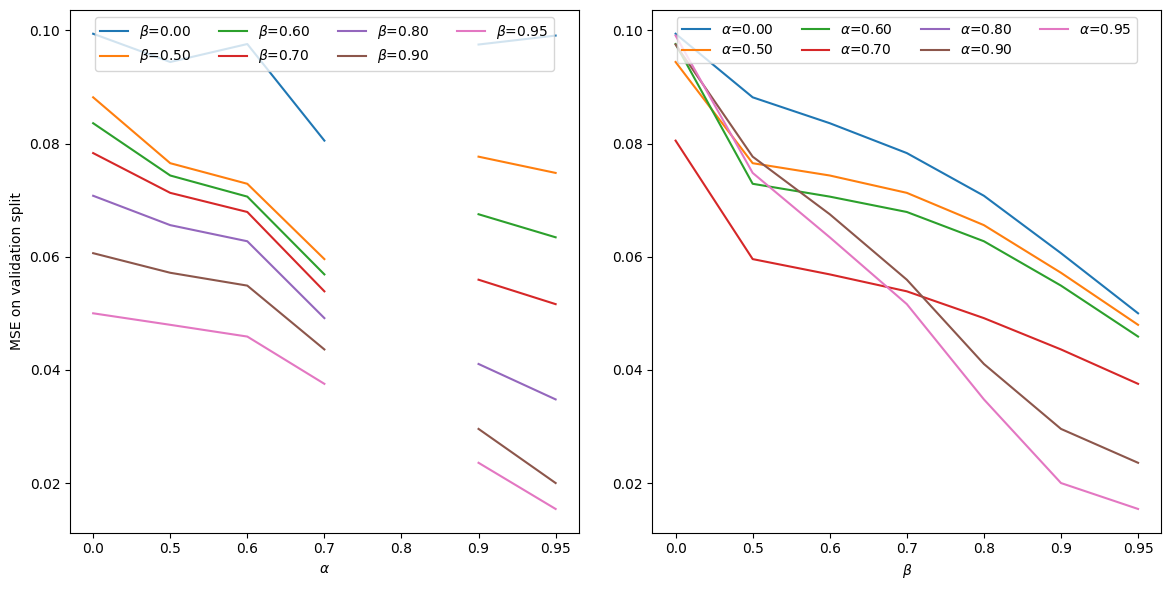

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=False)

ax = axs[0]
for beta in alpha_fake:
    series = res_df[res_df["beta"] == beta]
    ax.plot([str(round(x,2)) for x in series["alpha"]], series["mse"], label=f"$\\beta$={beta:.2f}")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE on validation split")
ax.legend(loc="upper center", ncols=4)

ax = axs[1]
for alpha in alpha_fake:
    series = res_df[res_df["alpha"] == alpha]
    ax.plot([str(round(x,2)) for x in series["beta"]], series["mse"], label=f"$\\alpha$={alpha:.2f}")
ax.set_xlabel("$\\beta$")
ax.legend(loc="upper center", ncols=4)

fig.tight_layout()

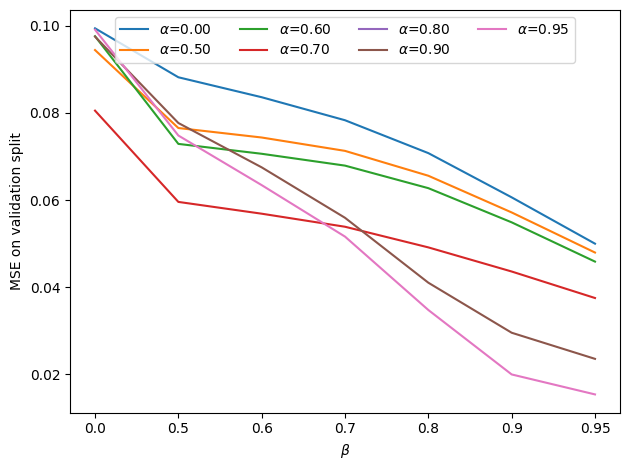

In [7]:
fig, ax = plt.subplots()
for alpha in alpha_fake:
    series = res_df[res_df["alpha"] == alpha]
    ax.plot([str(round(x,2)) for x in series["beta"]], series["mse"], label=f"$\\alpha$={alpha:.2f}")
ax.set_xlabel("$\\beta$")
ax.set_ylabel("MSE on validation split")
ax.legend(loc="upper center", ncols=4)
fig.savefig("plots/weights_experiment.png")
fig.tight_layout()

In [4]:
baseline_mse = jnp.mean(jnp.square(jnp.mean(target_train.q) - target_train.q))
baseline_mse_val = jnp.mean(jnp.square(jnp.mean(target_train.q) - target_validation.q))

In [5]:
optimized_params, optimizer_trace = nam.optimize_cma_es(
    nam.NAMParameters.from_physical(), observations_train, target_train, weights=weights_train[-3], abssum_weight=0,
    n_population=256, n_generations=128
)
with open("optimized_params.json", "w") as f:
    json.dump({k:float(x) for k,x in optimized_params._asdict().items()}, f)

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

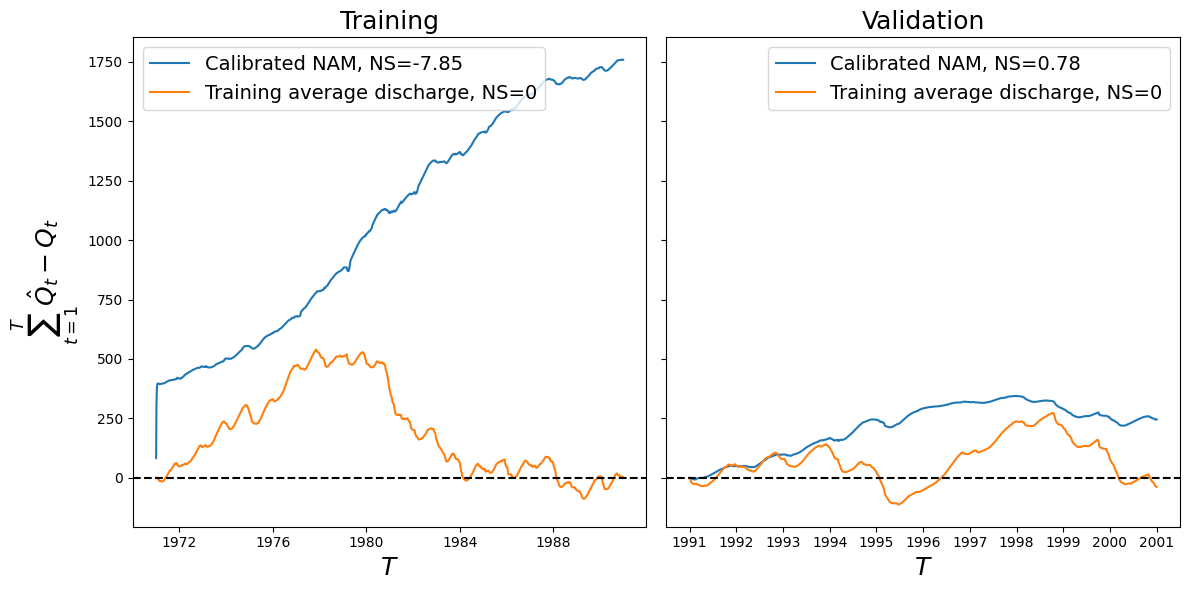

In [14]:
opt_par_val, pred_train = nam.predict(optimized_params, observations_train)
_, pred_val = nam.predict(opt_par_val, observations_validation)
mse_train = jnp.mean(jnp.square(pred_train.q - target_train.q))
ns_train = (baseline_mse - mse_train) / baseline_mse
mse_val = jnp.mean(jnp.square(pred_val.q - target_validation.q))
ns_val = (baseline_mse_val - mse_val) / baseline_mse_val

fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=True)
ax = axs[0]
ax.plot(timeseries_train["date"], jnp.cumsum(pred_train.q - target_train.q), label=f"Calibrated NAM, NS={ns_train:.2f}")
ax.plot(timeseries_train["date"], jnp.cumsum(jnp.mean(target_train.q) - target_train.q), label=f"Training average discharge, NS=0")
ax.axhline(y=0, linestyle="--", color="k")
ax.set_xlabel("$T$", fontsize=18)
ax.set_ylabel("$\\sum_{t=1}^T \\hat{Q}_t - Q_t$", fontsize=18)
ax.legend(fontsize=14)
ax.set_title("Training", fontsize=18)

ax = axs[1]
ax.plot(timeseries_validation["date"], jnp.cumsum(pred_val.q - target_validation.q), label=f"Calibrated NAM, NS={ns_val:.2f}")
ax.plot(timeseries_validation["date"], jnp.cumsum(jnp.mean(target_train.q) - target_validation.q), label=f"Training average discharge, NS=0")
ax.axhline(y=0, linestyle="--", color="k")
ax.set_xlabel("$T$", fontsize=18)
# ax.set_ylabel("$\\sum_{t=1}^T \\hat{Q}_t - Q_t$")
ax.legend(fontsize=14)
ax.set_title("Validation", fontsize=18)

fig.tight_layout()
fig.savefig("plots/cumulative_bias.png")

In [7]:
optimized_params_penalty, optimizer_trace = nam.optimize_cma_es(
    nam.NAMParameters.from_physical(), observations_train, target_train, weights=weights_train[-3], abssum_weight=1e-6,
    n_population=256, n_generations=128
)
with open("optimized_params_penalty.json", "w") as f:
    json.dump({k:float(x) for k,x in optimized_params_penalty._asdict().items()}, f)

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

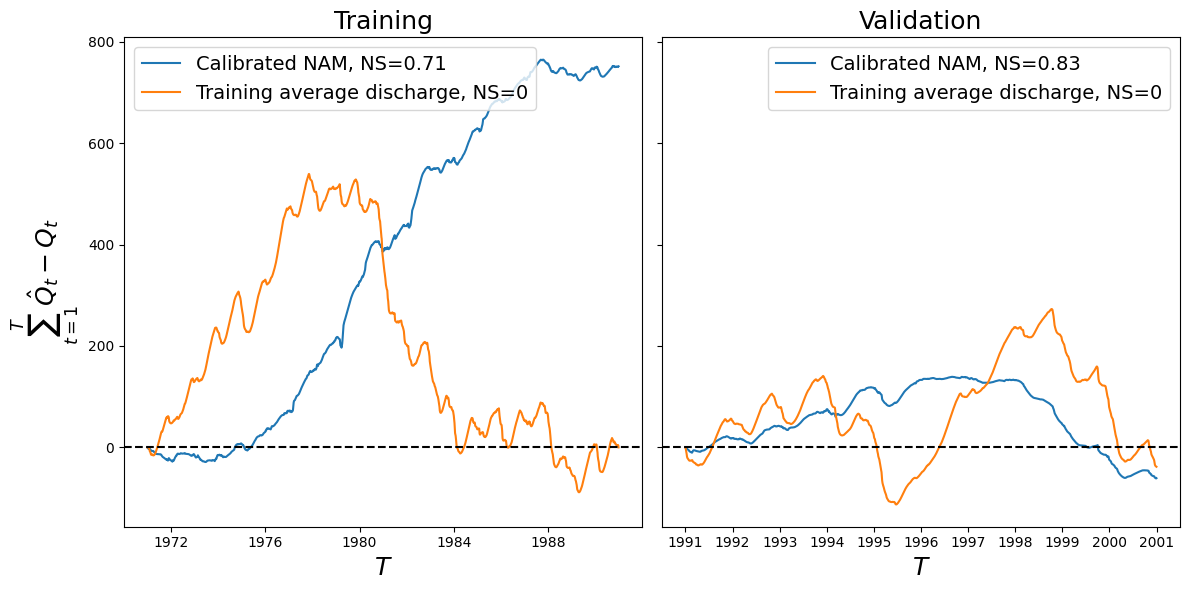

In [15]:
opt_par_val, pred_train = nam.predict(optimized_params_penalty, observations_train)
_, pred_val = nam.predict(opt_par_val, observations_validation)
mse_train = jnp.mean(jnp.square(pred_train.q - target_train.q))
ns_train = (baseline_mse - mse_train) / baseline_mse
mse_val = jnp.mean(jnp.square(pred_val.q - target_validation.q))
ns_val = (baseline_mse_val - mse_val) / baseline_mse_val

fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=True)
ax = axs[0]
ax.plot(timeseries_train["date"], jnp.cumsum(pred_train.q - target_train.q), label=f"Calibrated NAM, NS={ns_train:.2f}")
ax.plot(timeseries_train["date"], jnp.cumsum(jnp.mean(target_train.q) - target_train.q), label=f"Training average discharge, NS=0")
ax.axhline(y=0, linestyle="--", color="k")
ax.set_xlabel("$T$", fontsize=18)
ax.set_ylabel("$\\sum_{t=1}^T \\hat{Q}_t - Q_t$", fontsize=18)
ax.legend(fontsize=14)
ax.set_title("Training", fontsize=18)

ax = axs[1]
ax.plot(timeseries_validation["date"], jnp.cumsum(pred_val.q - target_validation.q), label=f"Calibrated NAM, NS={ns_val:.2f}")
ax.plot(timeseries_validation["date"], jnp.cumsum(jnp.mean(target_train.q) - target_validation.q), label=f"Training average discharge, NS=0")
ax.axhline(y=0, linestyle="--", color="k")
ax.set_xlabel("$T$", fontsize=18)
ax.legend(fontsize=14)
ax.set_title("Validation", fontsize=18)

fig.tight_layout()
fig.savefig("plots/cumulative_bias_penalty.png")

C:\Users\MUNRAS\AppData\Local\Temp\ipykernel_7828\1887332151.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


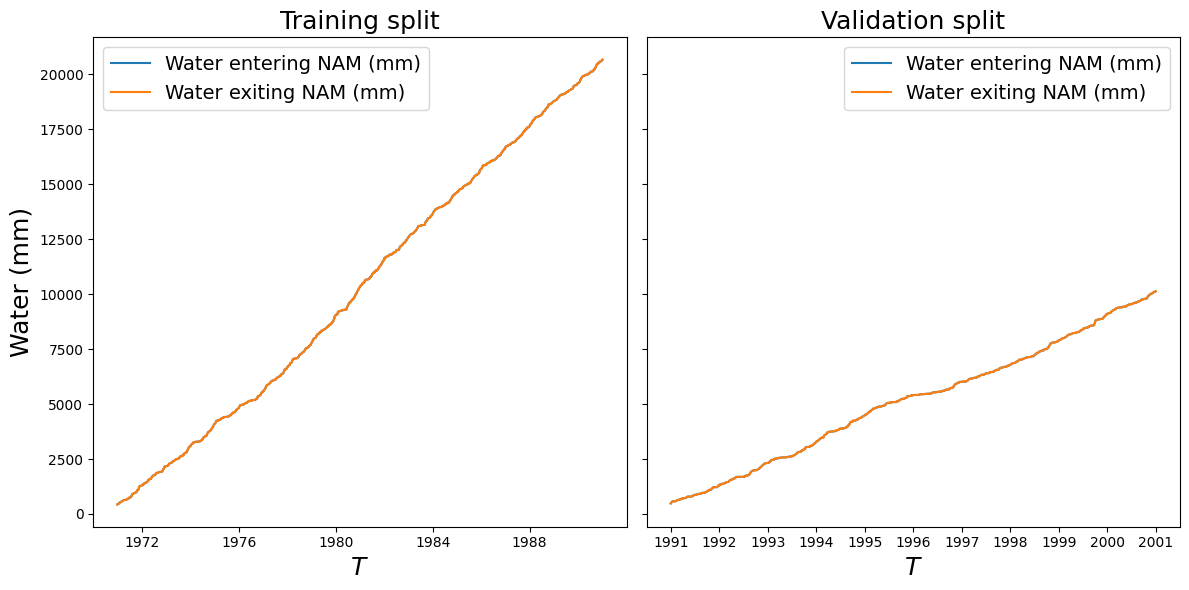

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=True)

water_in = optimized_params_penalty.total_water_stored() + jnp.cumsum(observations_train.p)
water_out = pred_train.storage + jnp.cumsum(pred_train.q + pred_train.eact + pred_train.perc)

ax = axs[0]
ax.plot(timeseries_train["date"], water_in, label=f"Water entering NAM (mm)")
ax.plot(timeseries_train["date"], water_out, label=f"Water exiting NAM (mm)")
ax.set_xlabel("$T$", fontsize=18)
ax.set_ylabel("Water (mm)", fontsize=18)
ax.legend(fontsize=14)
ax.set_title("Training split", fontsize=18)

water_in = opt_par_val.total_water_stored() + jnp.cumsum(observations_validation.p)
water_out = pred_val.storage + jnp.cumsum(pred_val.q + pred_val.eact + pred_val.perc)

ax = axs[1]
ax.plot(timeseries_validation["date"], water_in, label=f"Water entering NAM (mm)")
ax.plot(timeseries_validation["date"], water_out, label=f"Water exiting NAM (mm)")
ax.set_xlabel("$T$", fontsize=18)
ax.legend(fontsize=14)
ax.set_title("Validation split", fontsize=18)

fig.tight_layout()
fig.savefig("plots/water_balance.png")
fig.show()

In [4]:
with open("optimized_params_penalty.json", "r") as f:
    opt_par_penalty = NAMParameters(**json.load(f))

In [21]:
observations = nam.NAMObservation(
    p=jnp.asarray(timeseries["p"]),
    t=jnp.asarray(timeseries["t"]),
    epot=jnp.asarray(timeseries["epot"])
)
_, pred = nam.predict(opt_par_penalty, observations)
pred = pd.DataFrame(pred._asdict())
pred["date"] = timeseries["date"].reset_index(drop=True)
pred = pred.iloc[:-1]
pred = pred.merge(timeseries[["date", "p", "t", "epot"]], how="left", on="date")
pred.to_csv(path_to_data / "reference_predictions.csv", index=False)